# Problem description

Your goal is to predict the `total_cases` label for each `(city, year, weekofyear)` in the test set. There are two cities, San Juan and Iquitos, with test data for each city spanning 5 and 3 years respectively. You will make one submission that contains predictions for both cities. The data for each `city` have been concatenated along with a city column indicating the source: `sj` for San Juan and `iq` for Iquitos. The test set is a pure future hold-out, meaning the test data are sequential and non-overlapping with any of the training data. Throughout, missing values have been filled as `NaN`s.

## The features in this dataset
You are provided the following set of information on a `(year, weekofyear)` timescale:

(Where appropriate, units are provided as a `_unit` suffix on the feature name.)

## City and date indicators
- `city` – City abbreviations: sj for San Juan and iq for Iquitos
- `week_start_date` – Date given in yyyy-mm-dd format
## NOAA's GHCN daily climate data weather station measurements
- `station_max_temp_c` – Maximum temperature
- `station_min_temp_c` – Minimum temperature
- `station_avg_temp_c` – Average temperature
- `station_precip_mm` – Total precipitation
- `station_diur_temp_rng_c` – Diurnal temperature range
## PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)
- `precipitation_amt_mm` – Total precipitation
## NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)
- `reanalysis_sat_precip_amt_mm` – Total precipitation
- `reanalysis_dew_point_temp_k` – Mean dew point temperature
- `reanalysis_air_temp_k` – Mean air temperature
- `reanalysis_relative_humidity_percent` – Mean relative humidity
- `reanalysis_specific_humidity_g_per_kg` – Mean specific humidity
- `reanalysis_precip_amt_kg_per_m2` – Total precipitation
- `reanalysis_max_air_temp_k` – Maximum air temperature
- `reanalysis_min_air_temp_k` – Minimum air temperature
- `reanalysis_avg_temp_k` – Average air temperature
- `reanalysis_tdtr_k` – Diurnal temperature range
## Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements
- `ndvi_se` – Pixel southeast of city centroid
- `ndvi_sw` – Pixel southwest of city centroid
- `ndvi_ne` – Pixel northeast of city centroid
- `ndvi_nw` – Pixel northwest of city centroid

In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from src.d01_data.dengue_data_api import DengueDataApi, FEATURE_COLS, WEEK_START_DATE_COL, NDVI_COLS, \
PERSIANN_COLS, NOAA_NCEP_COLS, NOAA_GHCN_COLS, LOG_TRANSFORM

from src.d00_utils.utils import variable_analysis

# Exploratory Data Anaysis

In [2]:
from scipy import signal
dda = DengueDataApi()
x1, x2, y1, y2 = dda.split_data(random=False)
z1, z2, pct_var = dda.get_svd(x1, x2, num_components=5)
cities = x1.index.get_level_values('city').unique()

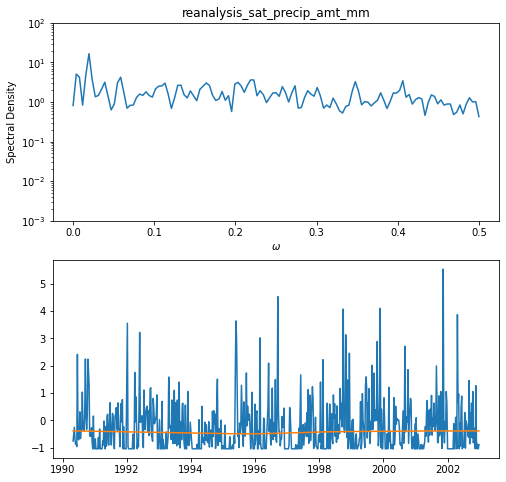

,power,t
0.019531,16.709603,51.200000
0.003906,5.081830,256.000000
0.015625,4.757892,64.000000
0.058594,4.228550,17.066667
0.007812,4.218655,128.000000


In [3]:
# col = np.random.choice(NDVI_COLS + NOAA_NCEP_COLS + NOAA_GHCN_COLS)
col = 'reanalysis_sat_precip_amt_mm'
city = np.random.choice(cities)

variable_analysis(x1[col].loc[city], col).head()

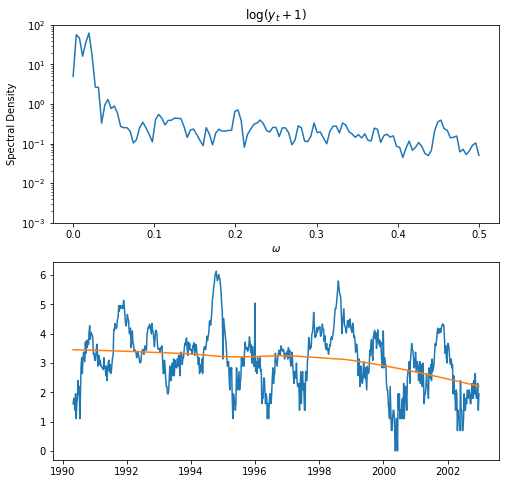

,power,t
0.019531,62.225074,51.200000
0.003906,56.417700,256.000000
0.007812,46.868314,128.000000
0.015625,35.903283,64.000000
0.023438,16.574553,42.666667


In [4]:
variable_analysis(y1.loc[city].apply(lambda x: np.log(x+1)), '$\\log(y_t+1)$').head()

## Spectral PCA

what's the difference between scaling `'density'` and `'spectrum'`?

In [5]:
n = len(x1.loc[city])
k = len(x1.columns)
Pxy = None
for i in range(k):
    for j in range(k):
        f, csd = signal.csd(x1.loc[city, x1.columns[i]], x1.loc[city, x1.columns[j]], scaling='density')
        if Pxy is None:
            Pxy = np.zeros([k, k, len(csd)])
        Pxy[i, j, :] = np.abs(csd)

In [6]:
spectral_pca = np.zeros([Pxy.shape[2], k])
for i in range(Pxy.shape[2]):
    w, v = np.linalg.eig(Pxy[:, :, i])
    spectral_pca[i, :] = list(reversed(sorted(np.abs(w))))
spectral_pca = pd.DataFrame(spectral_pca, columns=['lmda%i' % i  for i in range(k)], index=f)

In [7]:
spectral_pca['t'] = 1./spectral_pca.index.to_series()

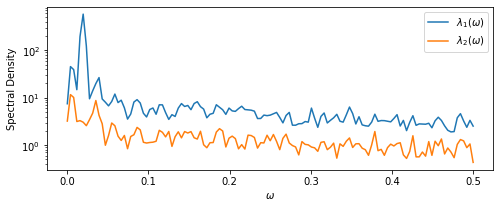

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
ax.semilogy(spectral_pca['lmda0'], label='$\lambda_1(\omega)$')
ax.semilogy(spectral_pca['lmda1'], label='$\lambda_2(\omega)$')

ax.legend()
ax.set_ylabel('Spectral Density')
ax.set_xlabel('$\omega$')
plt.show()